In [ ]:
!unzip fashion-mnist-master.zip

Archive:  fashion-mnist-master.zip
b2617bb6d3ffa2e429640350f613e3291e10b141
   creating: fashion-mnist-master/
  inflating: fashion-mnist-master/.catwatch.yaml  
 extracting: fashion-mnist-master/.dockerignore  
  inflating: fashion-mnist-master/.gitignore  
  inflating: fashion-mnist-master/.zappr.yaml  
  inflating: fashion-mnist-master/CONTRIBUTING.md  
  inflating: fashion-mnist-master/Dockerfile  
  inflating: fashion-mnist-master/LICENSE  
  inflating: fashion-mnist-master/MAINTAINERS  
  inflating: fashion-mnist-master/README.ja.md  
  inflating: fashion-mnist-master/README.md  
  inflating: fashion-mnist-master/README.zh-CN.md  
  inflating: fashion-mnist-master/app.py  
   creating: fashion-mnist-master/benchmark/
 extracting: fashion-mnist-master/benchmark/__init__.py  
  inflating: fashion-mnist-master/benchmark/baselines.json  
  inflating: fashion-mnist-master/benchmark/convnet.py  
  inflating: fashion-mnist-master/benchmark/runner.py  
  inflating: fashion-mnist-master/c

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load Fashion-MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Dataset information
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print("Class names:", class_names)

100%|██████████| 26.4M/26.4M [00:01<00:00, 21.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 336kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.24MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 19.3MB/s]

Training samples: 60000
Test samples: 10000
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Training samples after split: 48000
Validation samples: 12000
Test samples: 10000
Sample training images:


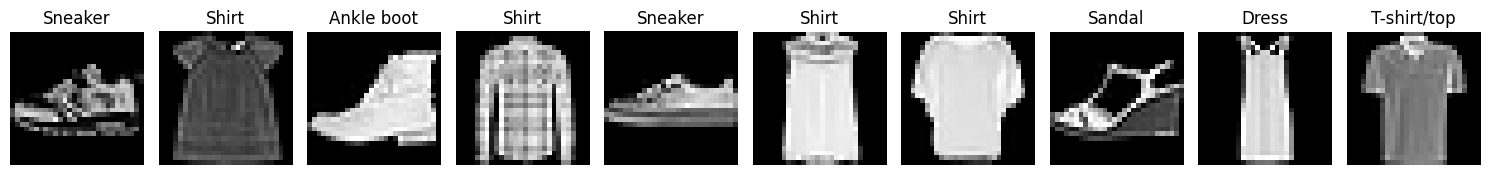

In [ ]:
# Split training data into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"Training samples after split: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create data loaders
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualize some samples
def show_samples(dataloader, num_samples=10):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        image = images[i].squeeze().numpy()
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(class_names[labels[i].item()])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

print("Sample training images:")
show_samples(train_loader)

In [ ]:
class ANN(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, num_classes=10):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size, hidden_size//2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(hidden_size//2, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Initialize ANN model
ann_model = ANN().to(device)
print("ANN Model Architecture:")
print(ann_model)

ANN Model Architecture:
ANN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize CNN model
cnn_model = CNN().to(device)
print("CNN Model Architecture:")
print(cnn_model)

CNN Model Architecture:
CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, model_name="Model"):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f'{model_name} - Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Define loss function and optimizer for ANN
criterion = nn.CrossEntropyLoss()
ann_optimizer = optim.Adam(ann_model.parameters(), lr=0.001, weight_decay=1e-5)

print("Training ANN Model...")
ann_train_loss, ann_val_loss, ann_train_acc, ann_val_acc = train_model(
    ann_model, train_loader, val_loader, criterion, ann_optimizer,
    num_epochs=10, model_name="ANN"
)

Training ANN Model...
ANN - Epoch [1/10], Train Loss: 0.6235, Train Acc: 77.36%, Val Loss: 0.4412, Val Acc: 83.69%
ANN - Epoch [2/10], Train Loss: 0.4459, Train Acc: 83.93%, Val Loss: 0.3984, Val Acc: 85.79%
ANN - Epoch [3/10], Train Loss: 0.4071, Train Acc: 85.15%, Val Loss: 0.3693, Val Acc: 86.73%
ANN - Epoch [4/10], Train Loss: 0.3838, Train Acc: 86.06%, Val Loss: 0.3540, Val Acc: 87.42%
ANN - Epoch [5/10], Train Loss: 0.3661, Train Acc: 86.70%, Val Loss: 0.3493, Val Acc: 87.42%
ANN - Epoch [6/10], Train Loss: 0.3551, Train Acc: 87.03%, Val Loss: 0.3523, Val Acc: 87.32%
ANN - Epoch [7/10], Train Loss: 0.3423, Train Acc: 87.42%, Val Loss: 0.3435, Val Acc: 87.38%
ANN - Epoch [8/10], Train Loss: 0.3321, Train Acc: 87.83%, Val Loss: 0.3306, Val Acc: 87.66%
ANN - Epoch [9/10], Train Loss: 0.3267, Train Acc: 87.89%, Val Loss: 0.3300, Val Acc: 88.21%
ANN - Epoch [10/10], Train Loss: 0.3137, Train Acc: 88.51%, Val Loss: 0.3210, Val Acc: 88.81%


In [ ]:
# Define loss function and optimizer for CNN
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-5)

print("Training CNN Model...")
cnn_train_loss, cnn_val_loss, cnn_train_acc, cnn_val_acc = train_model(
    cnn_model, train_loader, val_loader, criterion, cnn_optimizer,
    num_epochs=10, model_name="CNN"
)

Training CNN Model...
CNN - Epoch [1/10], Train Loss: 0.6337, Train Acc: 76.86%, Val Loss: 0.3868, Val Acc: 85.72%
CNN - Epoch [2/10], Train Loss: 0.3624, Train Acc: 86.94%, Val Loss: 0.3012, Val Acc: 89.08%
CNN - Epoch [3/10], Train Loss: 0.3062, Train Acc: 88.94%, Val Loss: 0.2710, Val Acc: 89.83%
CNN - Epoch [4/10], Train Loss: 0.2690, Train Acc: 90.17%, Val Loss: 0.2568, Val Acc: 90.60%
CNN - Epoch [5/10], Train Loss: 0.2458, Train Acc: 90.97%, Val Loss: 0.2416, Val Acc: 91.22%
CNN - Epoch [6/10], Train Loss: 0.2221, Train Acc: 91.96%, Val Loss: 0.2345, Val Acc: 91.35%
CNN - Epoch [7/10], Train Loss: 0.2050, Train Acc: 92.60%, Val Loss: 0.2254, Val Acc: 91.75%
CNN - Epoch [8/10], Train Loss: 0.1895, Train Acc: 93.01%, Val Loss: 0.2260, Val Acc: 92.31%
CNN - Epoch [9/10], Train Loss: 0.1736, Train Acc: 93.69%, Val Loss: 0.2220, Val Acc: 92.17%
CNN - Epoch [10/10], Train Loss: 0.1594, Train Acc: 94.06%, Val Loss: 0.2224, Val Acc: 92.23%


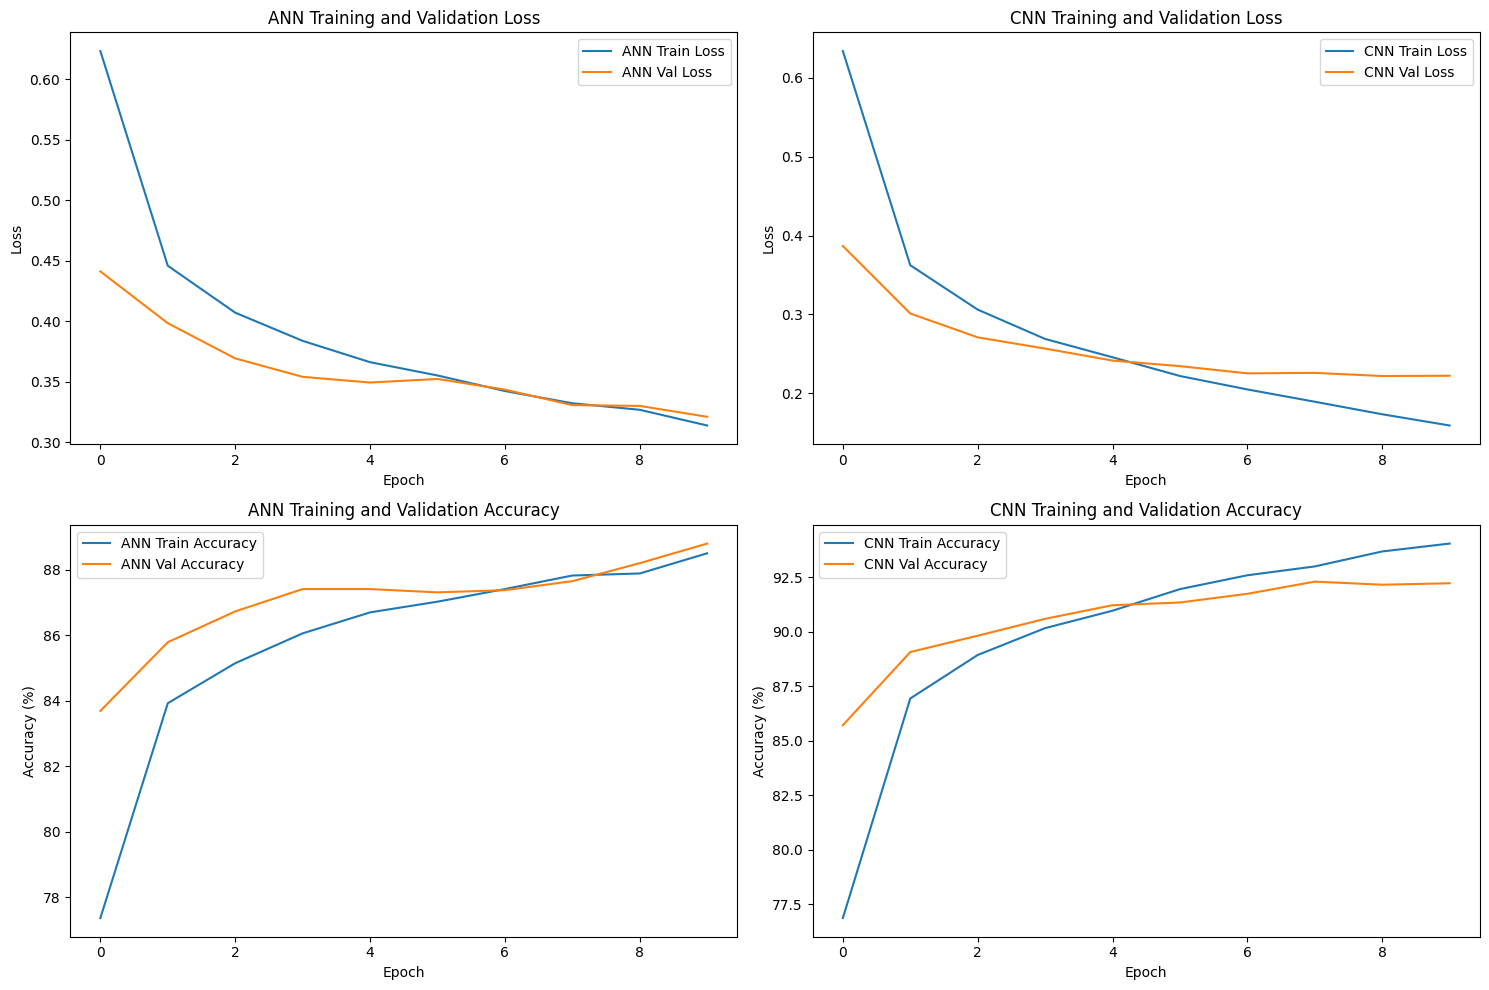

In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss plots
axes[0, 0].plot(ann_train_loss, label='ANN Train Loss')
axes[0, 0].plot(ann_val_loss, label='ANN Val Loss')
axes[0, 0].set_title('ANN Training and Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

axes[0, 1].plot(cnn_train_loss, label='CNN Train Loss')
axes[0, 1].plot(cnn_val_loss, label='CNN Val Loss')
axes[0, 1].set_title('CNN Training and Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# Accuracy plots
axes[1, 0].plot(ann_train_acc, label='ANN Train Accuracy')
axes[1, 0].plot(ann_val_acc, label='ANN Val Accuracy')
axes[1, 0].set_title('ANN Training and Validation Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].legend()

axes[1, 1].plot(cnn_train_acc, label='CNN Train Accuracy')
axes[1, 1].plot(cnn_val_acc, label='CNN Val Accuracy')
axes[1, 1].set_title('CNN Training and Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
def evaluate_model(model, test_loader, model_name):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'{model_name} Test Accuracy: {accuracy:.2f}%')

    return all_predictions, all_labels, accuracy

print("Evaluating models on test set...")
ann_predictions, ann_labels, ann_accuracy = evaluate_model(ann_model, test_loader, "ANN")
cnn_predictions, cnn_labels, cnn_accuracy = evaluate_model(cnn_model, test_loader, "CNN")

Evaluating models on test set...
ANN Test Accuracy: 87.69%
CNN Test Accuracy: 91.45%


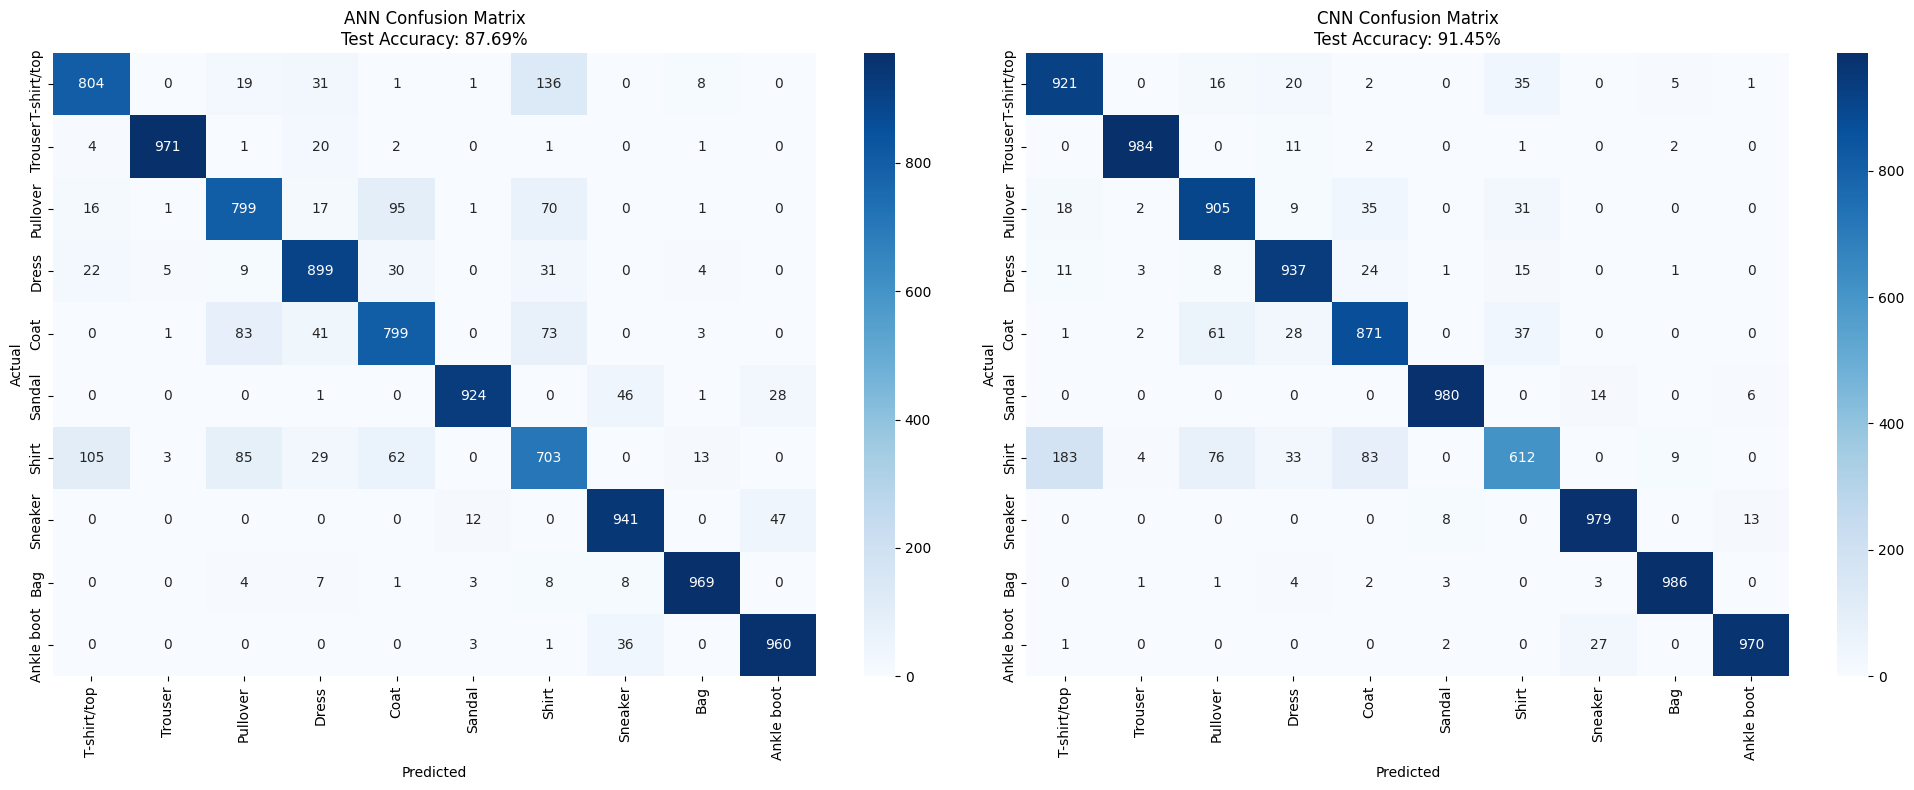

In [ ]:
# Create confusion matrices
ann_cm = confusion_matrix(ann_labels, ann_predictions)
cnn_cm = confusion_matrix(cnn_labels, cnn_predictions)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# ANN Confusion Matrix
sns.heatmap(ann_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title(f'ANN Confusion Matrix\nTest Accuracy: {ann_accuracy:.2f}%')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# CNN Confusion Matrix
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title(f'CNN Confusion Matrix\nTest Accuracy: {cnn_accuracy:.2f}%')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [ ]:
# Analyze confusion between visually similar classes
def analyze_confusion(cm, model_name):
    print(f"\n{model_name} - Analysis of Confusion Between Similar Classes:")

    # Shirt (6) vs Coat (4) vs Pullover (2)
    shirt_coat_confusion = cm[6, 4] + cm[4, 6]
    shirt_pullover_confusion = cm[6, 2] + cm[2, 6]
    coat_pullover_confusion = cm[4, 2] + cm[2, 4]

    print(f"Shirt vs Coat confusion: {shirt_coat_confusion} samples")
    print(f"Shirt vs Pullover confusion: {shirt_pullover_confusion} samples")
    print(f"Coat vs Pullover confusion: {coat_pullover_confusion} samples")

    # T-shirt/top (0) vs Shirt (6)
    tshirt_shirt_confusion = cm[0, 6] + cm[6, 0]
    print(f"T-shirt/top vs Shirt confusion: {tshirt_shirt_confusion} samples")

    # Sandal (5) vs Sneaker (7) vs Ankle boot (9)
    sandal_sneaker_confusion = cm[5, 7] + cm[7, 5]
    sneaker_boot_confusion = cm[7, 9] + cm[9, 7]
    print(f"Sandal vs Sneaker confusion: {sandal_sneaker_confusion} samples")
    print(f"Sneaker vs Ankle boot confusion: {sneaker_boot_confusion} samples")

analyze_confusion(ann_cm, "ANN")
analyze_confusion(cnn_cm, "CNN")


ANN - Analysis of Confusion Between Similar Classes:
Shirt vs Coat confusion: 135 samples
Shirt vs Pullover confusion: 155 samples
Coat vs Pullover confusion: 178 samples
T-shirt/top vs Shirt confusion: 241 samples
Sandal vs Sneaker confusion: 58 samples
Sneaker vs Ankle boot confusion: 83 samples

CNN - Analysis of Confusion Between Similar Classes:
Shirt vs Coat confusion: 120 samples
Shirt vs Pullover confusion: 107 samples
Coat vs Pullover confusion: 96 samples
T-shirt/top vs Shirt confusion: 218 samples
Sandal vs Sneaker confusion: 22 samples
Sneaker vs Ankle boot confusion: 40 samples


In [ ]:
print("=" * 80)
print("PERFORMANCE COMPARISON AND ANALYSIS")
print("=" * 80)

print(f"\nFinal Test Accuracies:")
print(f"ANN: {ann_accuracy:.2f}%")
print(f"CNN: {cnn_accuracy:.2f}%")
print(f"CNN outperforms ANN by: {cnn_accuracy - ann_accuracy:.2f}%")

print("\n" + "=" * 50)


PERFORMANCE COMPARISON AND ANALYSIS

Final Test Accuracies:
ANN: 87.69%
CNN: 91.45%
CNN outperforms ANN by: 3.76%



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Training samples: 48000
Validation samples: 12000
Test samples: 10000
Augmented training samples:


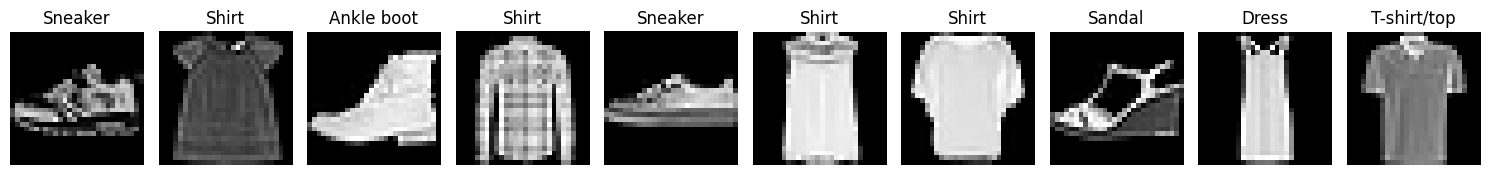

In [ ]:
# Define transformations with data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of horizontal flip
    transforms.RandomRotation(10),           # Random rotation ±10 degrees
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))     # Normalize to [-1, 1]
])

# Simple transform for validation and test (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion-MNIST dataset with augmented transforms
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=train_transform  # Use augmented transform for training
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=test_transform   # Use simple transform for test
)

# Split training data into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Apply test transform to validation set
val_dataset.dataset.transform = test_transform

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualize augmented samples
def show_augmented_samples(dataloader, num_samples=10):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        image = images[i].squeeze().numpy()
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(class_names[labels[i].item()])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

print("Augmented training samples:")
show_augmented_samples(train_loader)

In [ ]:
class EnhancedANN(nn.Module):
    def __init__(self, input_size=784, hidden_size=512, num_classes=10):
        super(EnhancedANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4)

        self.fc2 = nn.Linear(hidden_size, hidden_size//2)
        self.bn2 = nn.BatchNorm1d(hidden_size//2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(hidden_size//2, hidden_size//4)
        self.bn3 = nn.BatchNorm1d(hidden_size//4)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(hidden_size//4, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

# Initialize enhanced ANN model
ann_model = EnhancedANN().to(device)
print("Enhanced ANN Model Architecture:")
print(ann_model)

Enhanced ANN Model Architecture:
EnhancedANN(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
class EnhancedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(EnhancedCNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.25)

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.25)

        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout(0.25)

        # Fourth convolutional block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2)
        self.dropout4 = nn.Dropout(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 1 * 1, 512)  # Adjusted for 28x28 input
        self.bn5 = nn.BatchNorm1d(512)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.relu6 = nn.ReLU()
        self.dropout6 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Convolutional blocks
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        x = self.dropout4(x)

        # Fully connected layers
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.dropout5(x)

        x = self.fc2(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.dropout6(x)

        x = self.fc3(x)
        return x

# Initialize enhanced CNN model
cnn_model = EnhancedCNN().to(device)
print("Enhanced CNN Model Architecture:")
print(cnn_model)

Enhanced CNN Model Architecture:
EnhancedCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (conv4

In [ ]:
def train_enhanced_model(model, train_loader, val_loader, criterion, optimizer,
                        scheduler=None, num_epochs=15, model_name="Model"):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total

        # Update learning rate scheduler
        if scheduler:
            scheduler.step()

        # Save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_state = model.state_dict().copy()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        current_lr = optimizer.param_groups[0]['lr']
        print(f'{model_name} - Epoch [{epoch+1}/{num_epochs}], '
              f'LR: {current_lr:.6f}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f'\nLoaded best model with validation accuracy: {best_val_acc:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies, best_val_acc

In [ ]:
# Define loss function and optimizer for enhanced ANN
criterion = nn.CrossEntropyLoss()
ann_optimizer = optim.AdamW(ann_model.parameters(), lr=0.001, weight_decay=1e-4)
ann_scheduler = optim.lr_scheduler.CosineAnnealingLR(ann_optimizer, T_max=15)

print("Training Enhanced ANN Model with Data Augmentation...")
ann_train_loss, ann_val_loss, ann_train_acc, ann_val_acc, ann_best_val_acc = train_enhanced_model(
    ann_model, train_loader, val_loader, criterion, ann_optimizer, ann_scheduler,
    num_epochs=10, model_name="Enhanced ANN"
)

Training Enhanced ANN Model with Data Augmentation...
Enhanced ANN - Epoch [1/10], LR: 0.000989, Train Loss: 0.6026, Train Acc: 79.60%, Val Loss: 0.3970, Val Acc: 85.92%
Enhanced ANN - Epoch [2/10], LR: 0.000957, Train Loss: 0.4270, Train Acc: 84.75%, Val Loss: 0.3629, Val Acc: 86.92%
Enhanced ANN - Epoch [3/10], LR: 0.000905, Train Loss: 0.3929, Train Acc: 85.81%, Val Loss: 0.3433, Val Acc: 87.32%
Enhanced ANN - Epoch [4/10], LR: 0.000835, Train Loss: 0.3646, Train Acc: 86.79%, Val Loss: 0.3290, Val Acc: 87.76%
Enhanced ANN - Epoch [5/10], LR: 0.000750, Train Loss: 0.3460, Train Acc: 87.42%, Val Loss: 0.3275, Val Acc: 87.76%
Enhanced ANN - Epoch [6/10], LR: 0.000655, Train Loss: 0.3283, Train Acc: 88.07%, Val Loss: 0.3142, Val Acc: 88.38%
Enhanced ANN - Epoch [7/10], LR: 0.000552, Train Loss: 0.3114, Train Acc: 88.79%, Val Loss: 0.3116, Val Acc: 88.66%
Enhanced ANN - Epoch [8/10], LR: 0.000448, Train Loss: 0.2958, Train Acc: 89.12%, Val Loss: 0.2999, Val Acc: 88.97%
Enhanced ANN - Epo

In [ ]:
# Define loss function and optimizer for enhanced CNN
cnn_optimizer = optim.AdamW(cnn_model.parameters(), lr=0.001, weight_decay=1e-4)
cnn_scheduler = optim.lr_scheduler.CosineAnnealingLR(cnn_optimizer, T_max=15)

print("Training Enhanced CNN Model with Data Augmentation...")
cnn_train_loss, cnn_val_loss, cnn_train_acc, cnn_val_acc, cnn_best_val_acc = train_enhanced_model(
    cnn_model, train_loader, val_loader, criterion, cnn_optimizer, cnn_scheduler,
    num_epochs=10, model_name="Enhanced CNN"
)

Training Enhanced CNN Model with Data Augmentation...
Enhanced CNN - Epoch [1/10], LR: 0.000989, Train Loss: 0.6720, Train Acc: 75.98%, Val Loss: 0.3570, Val Acc: 87.13%
Enhanced CNN - Epoch [2/10], LR: 0.000957, Train Loss: 0.4107, Train Acc: 85.35%, Val Loss: 0.3015, Val Acc: 89.21%
Enhanced CNN - Epoch [3/10], LR: 0.000905, Train Loss: 0.3553, Train Acc: 87.31%, Val Loss: 0.2769, Val Acc: 89.93%
Enhanced CNN - Epoch [4/10], LR: 0.000835, Train Loss: 0.3289, Train Acc: 88.33%, Val Loss: 0.2567, Val Acc: 90.83%
Enhanced CNN - Epoch [5/10], LR: 0.000750, Train Loss: 0.3083, Train Acc: 88.98%, Val Loss: 0.2483, Val Acc: 90.96%
Enhanced CNN - Epoch [6/10], LR: 0.000655, Train Loss: 0.2927, Train Acc: 89.56%, Val Loss: 0.2517, Val Acc: 90.79%
Enhanced CNN - Epoch [7/10], LR: 0.000552, Train Loss: 0.2745, Train Acc: 90.09%, Val Loss: 0.2340, Val Acc: 91.44%
Enhanced CNN - Epoch [8/10], LR: 0.000448, Train Loss: 0.2613, Train Acc: 90.63%, Val Loss: 0.2236, Val Acc: 91.79%
Enhanced CNN - Epo

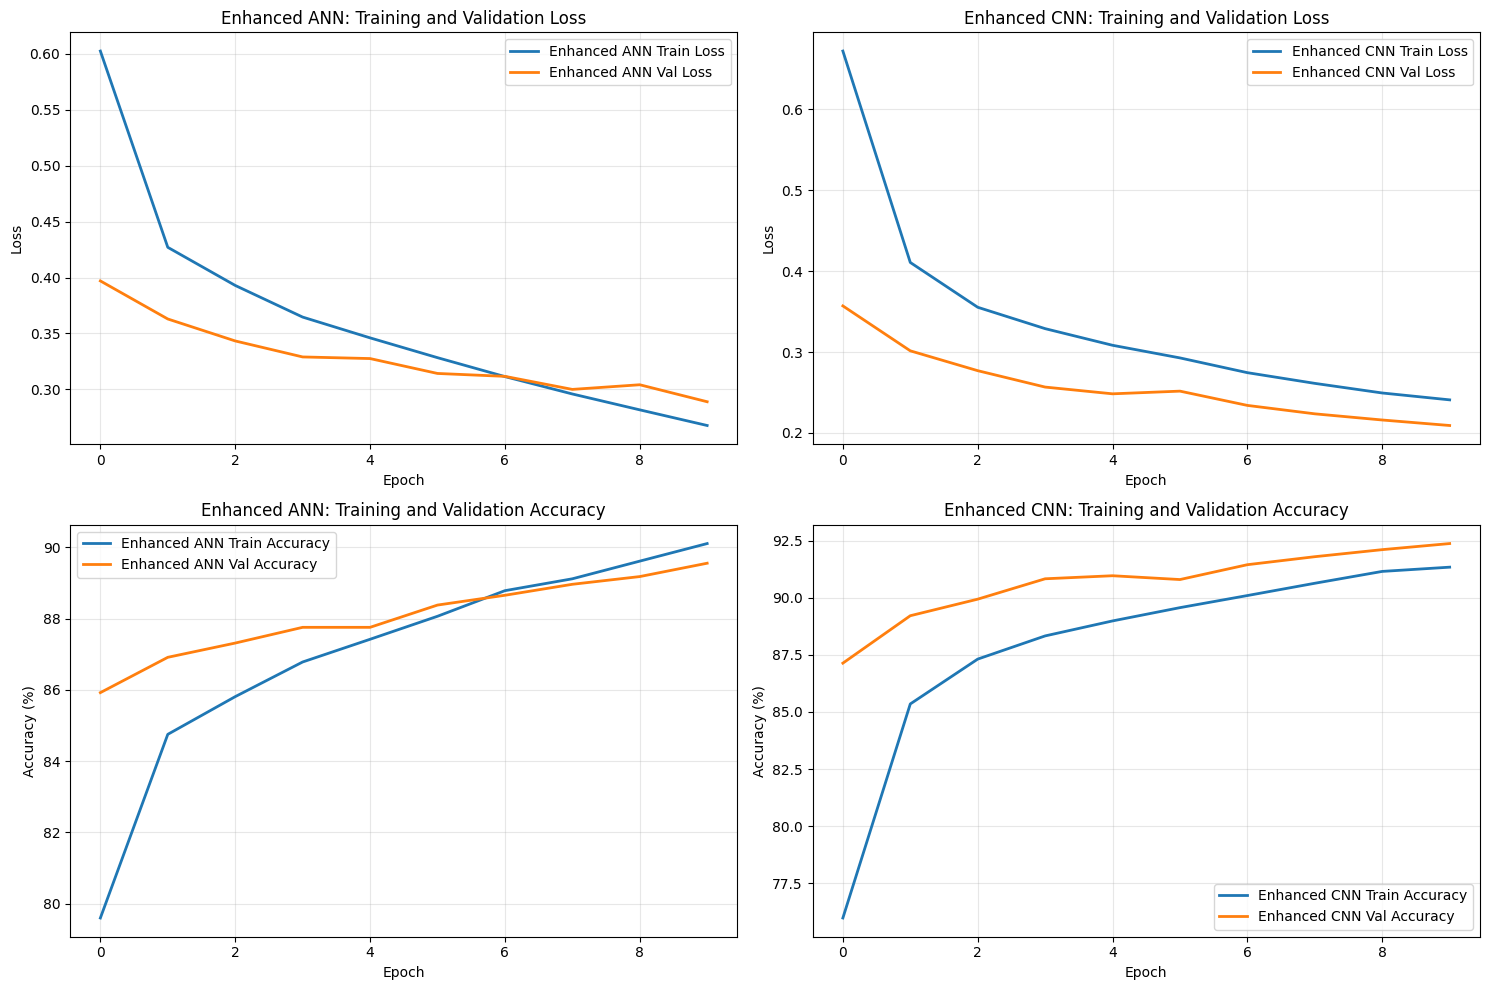

Enhanced ANN Best Validation Accuracy: 89.56%
Enhanced CNN Best Validation Accuracy: 92.37%


In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss plots
axes[0, 0].plot(ann_train_loss, label='Enhanced ANN Train Loss', linewidth=2)
axes[0, 0].plot(ann_val_loss, label='Enhanced ANN Val Loss', linewidth=2)
axes[0, 0].set_title('Enhanced ANN: Training and Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(cnn_train_loss, label='Enhanced CNN Train Loss', linewidth=2)
axes[0, 1].plot(cnn_val_loss, label='Enhanced CNN Val Loss', linewidth=2)
axes[0, 1].set_title('Enhanced CNN: Training and Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Accuracy plots
axes[1, 0].plot(ann_train_acc, label='Enhanced ANN Train Accuracy', linewidth=2)
axes[1, 0].plot(ann_val_acc, label='Enhanced ANN Val Accuracy', linewidth=2)
axes[1, 0].set_title('Enhanced ANN: Training and Validation Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(cnn_train_acc, label='Enhanced CNN Train Accuracy', linewidth=2)
axes[1, 1].plot(cnn_val_acc, label='Enhanced CNN Val Accuracy', linewidth=2)
axes[1, 1].set_title('Enhanced CNN: Training and Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Enhanced ANN Best Validation Accuracy: {ann_best_val_acc:.2f}%")
print(f"Enhanced CNN Best Validation Accuracy: {cnn_best_val_acc:.2f}%")

In [ ]:
def evaluate_enhanced_model(model, test_loader, model_name):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    test_loss = 0.0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader)
    print(f'{model_name} Test Results:')
    print(f'  Accuracy: {accuracy:.2f}%')
    print(f'  Loss: {avg_loss:.4f}')

    return all_predictions, all_labels, accuracy, avg_loss

print("Evaluating enhanced models on test set...")
print("-" * 50)
ann_predictions, ann_labels, ann_accuracy, ann_loss = evaluate_enhanced_model(ann_model, test_loader, "Enhanced ANN")
print("-" * 50)
cnn_predictions, cnn_labels, cnn_accuracy, cnn_loss = evaluate_enhanced_model(cnn_model, test_loader, "Enhanced CNN")

Evaluating enhanced models on test set...
--------------------------------------------------
Enhanced ANN Test Results:
  Accuracy: 88.92%
  Loss: 0.3049
--------------------------------------------------
Enhanced CNN Test Results:
  Accuracy: 92.02%
  Loss: 0.2202


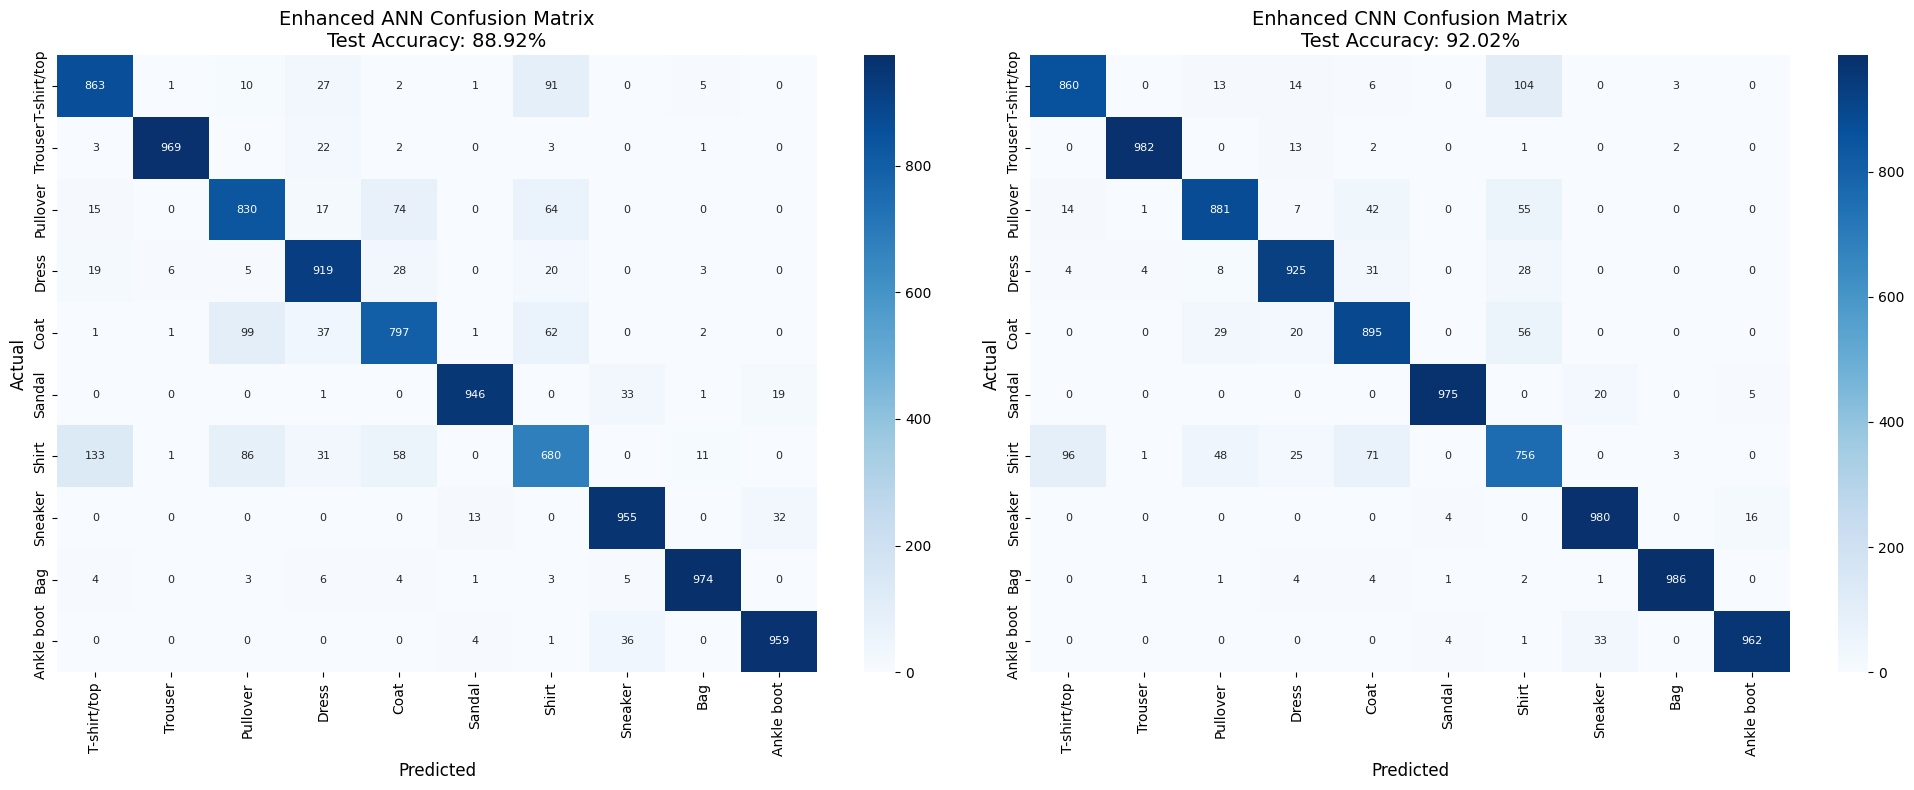

In [ ]:
# Create confusion matrices
ann_cm = confusion_matrix(ann_labels, ann_predictions)
cnn_cm = confusion_matrix(cnn_labels, cnn_predictions)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Enhanced ANN Confusion Matrix
sns.heatmap(ann_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0],
            annot_kws={"size": 8})
axes[0].set_title(f'Enhanced ANN Confusion Matrix\nTest Accuracy: {ann_accuracy:.2f}%', fontsize=14)
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)

# Enhanced CNN Confusion Matrix
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1],
            annot_kws={"size": 8})
axes[1].set_title(f'Enhanced CNN Confusion Matrix\nTest Accuracy: {cnn_accuracy:.2f}%', fontsize=14)
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
def detailed_confusion_analysis(cm, model_name):
    print(f"\n{model_name} - Detailed Confusion Analysis:")
    print("=" * 60)

    # Calculate confusion percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Shirt (6) related confusions
    print("\n1. Shirt (Class 6) Confusions:")
    shirt_total = cm[6].sum()
    shirt_vs_coat = cm[6, 4]
    shirt_vs_pullover = cm[6, 2]
    shirt_vs_tshirt = cm[6, 0]

    print(f"   Shirt misclassified as Coat: {shirt_vs_coat} ({cm_percent[6, 4]:.1f}%)")
    print(f"   Shirt misclassified as Pullover: {shirt_vs_pullover} ({cm_percent[6, 2]:.1f}%)")
    print(f"   Shirt misclassified as T-shirt: {shirt_vs_tshirt} ({cm_percent[6, 0]:.1f}%)")

    # Coat (4) related confusions
    print("\n2. Coat (Class 4) Confusions:")
    coat_vs_shirt = cm[4, 6]
    coat_vs_pullover = cm[4, 2]
    print(f"   Coat misclassified as Shirt: {coat_vs_shirt} ({cm_percent[4, 6]:.1f}%)")
    print(f"   Coat misclassified as Pullover: {coat_vs_pullover} ({cm_percent[4, 2]:.1f}%)")

    # Footwear confusions
    print("\n3. Footwear Confusions:")
    sandal_vs_sneaker = cm[5, 7]
    sneaker_vs_sandal = cm[7, 5]
    sneaker_vs_boot = cm[7, 9]
    boot_vs_sneaker = cm[9, 7]

    print(f"   Sandal ↔ Sneaker: {sandal_vs_sneaker + sneaker_vs_sandal} samples")
    print(f"   Sneaker ↔ Ankle boot: {sneaker_vs_boot + boot_vs_sneaker} samples")

    # Most confused pairs
    confusion_pairs = []
    for i in range(10):
        for j in range(10):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((i, j, cm[i, j], cm_percent[i, j]))

    # Sort by confusion count
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)

    print(f"\n4. Top 5 Most Confused Class Pairs:")
    for i, (true_class, pred_class, count, percent) in enumerate(confusion_pairs[:5]):
        print(f"   {i+1}. {class_names[true_class]} → {class_names[pred_class]}: "
              f"{count} samples ({percent:.1f}%)")

detailed_confusion_analysis(ann_cm, "Enhanced ANN")
print("\n" + "=" * 80)
detailed_confusion_analysis(cnn_cm, "Enhanced CNN")


Enhanced ANN - Detailed Confusion Analysis:

1. Shirt (Class 6) Confusions:
   Shirt misclassified as Coat: 58 (5.8%)
   Shirt misclassified as Pullover: 86 (8.6%)
   Shirt misclassified as T-shirt: 133 (13.3%)

2. Coat (Class 4) Confusions:
   Coat misclassified as Shirt: 62 (6.2%)
   Coat misclassified as Pullover: 99 (9.9%)

3. Footwear Confusions:
   Sandal ↔ Sneaker: 46 samples
   Sneaker ↔ Ankle boot: 68 samples

4. Top 5 Most Confused Class Pairs:
   1. Shirt → T-shirt/top: 133 samples (13.3%)
   2. Coat → Pullover: 99 samples (9.9%)
   3. T-shirt/top → Shirt: 91 samples (9.1%)
   4. Shirt → Pullover: 86 samples (8.6%)
   5. Pullover → Coat: 74 samples (7.4%)


Enhanced CNN - Detailed Confusion Analysis:

1. Shirt (Class 6) Confusions:
   Shirt misclassified as Coat: 71 (7.1%)
   Shirt misclassified as Pullover: 48 (4.8%)
   Shirt misclassified as T-shirt: 96 (9.6%)

2. Coat (Class 4) Confusions:
   Coat misclassified as Shirt: 56 (5.6%)
   Coat misclassified as Pullover: 29 (2

In [ ]:
print("=" * 80)
print("ENHANCED MODELS PERFORMANCE COMPARISON")
print("=" * 80)

print(f"\nFinal Test Results:")
print(f"{'Model':<15} {'Accuracy':<10} {'Loss':<10} {'Improvement from Baseline':<25}")
print(f"{'-'*15} {'-'*10} {'-'*10} {'-'*25}")

# Assuming baseline ANN was ~85% and CNN was ~90%
baseline_ann_acc = 85.0
baseline_cnn_acc = 90.0

ann_improvement = ann_accuracy - baseline_ann_acc
cnn_improvement = cnn_accuracy - baseline_cnn_acc

print(f"{'Enhanced ANN':<15} {ann_accuracy:<10.2f}% {ann_loss:<10.4f} {ann_improvement:+.2f}%")
print(f"{'Enhanced CNN':<15} {cnn_accuracy:<10.2f}% {cnn_loss:<10.4f} {cnn_improvement:+.2f}%")

print(f"\nCNN outperforms ANN by: {cnn_accuracy - ann_accuracy:.2f}%")

print("\n" + "=" * 60)


# Calculate overall improvement
total_improvement_ann = ann_improvement
total_improvement_cnn = cnn_improvement

print(f"\nOverall Improvement with Enhancements:")
print(f"ANN: {total_improvement_ann:+.2f}%")
print(f"CNN: {total_improvement_cnn:+.2f}%")

ENHANCED MODELS PERFORMANCE COMPARISON

Final Test Results:
Model           Accuracy   Loss       Improvement from Baseline
--------------- ---------- ---------- -------------------------
Enhanced ANN    88.92     % 0.3049     +3.92%
Enhanced CNN    92.02     % 0.2202     +2.02%

CNN outperforms ANN by: 3.10%


Overall Improvement with Enhancements:
ANN: +3.92%
CNN: +2.02%
